# Adaptive RAG with Azure AI Evaluation SDK

----

In this notebook, we will demonstrate how to use the Azure AI Evaluation SDK.

> ✨ ***Note*** <br>
> 1. Please check the reference document before you get started - https://learn.microsoft.com/en-us/azure/ai-studio/how-to/develop/evaluate-sdk <br>
> 2. Check the region support for the Azure AI Evaluation SDK. https://learn.microsoft.com/en-us/azure/ai-studio/concepts/evaluation-metrics-built-in?tabs=warning#region-support


Adaptive RAG predicts the **complexity of the input question** using a SLM/LLM and selects an appropriate processing workflow accordingly.

- **Very simple question (No Retrieval)**: Generates answers without RAG.
- **Simple question (Single-shot RAG)**: Efficiently generates answers through a single-step search and generation.
- **Complex question (Iterative RAG)**: Provides accurate answers to complex questions through repeated multi-step search and generation.


Adaptive-RAG, Self-RAG, and Corrective RAG are similar approach, but they have different focuses.

- **Adaptive-RAG**: Dynamically selects appropriate retrieval and generation strategies based on the complexity of the question.
- **Self-RAG**: The model determines the need for retrieval on its own, performs retrieval when necessary, and improves the quality through self-reflection on the generated answers.
- **Corrective RAG**: Evaluates the quality of retrieved documents, and performs additional retrievals such as web searches to supplement the information if the reliability is low.

**Reference**

- [Adaptive-RAG paper](https://arxiv.org/abs/2403.14403)  

In [1]:
from dotenv import load_dotenv
from azure_genai_utils.tracer import get_langchain_api_key, set_langsmith

load_dotenv()

# If you want to trace your RAG API calls, please set the tracing=True. You need to have a valid Langchain API key.
langchain_key, has_langchain_key = get_langchain_api_key()
set_langsmith("[RAG Innv Lab] 1_Agentic-Design-Pattern", tracing=False)

Does not use LangSmith tracing.


In [2]:
import os
import pprint
from azure.identity import DefaultAzureCredential
from azure.ai.evaluation import evaluate
from azure.ai.evaluation import (
    ContentSafetyEvaluator,
    RelevanceEvaluator,
    CoherenceEvaluator,
    GroundednessEvaluator,
    FluencyEvaluator,
    SimilarityEvaluator,
    F1ScoreEvaluator,
    RetrievalEvaluator,
)

credential = DefaultAzureCredential()

# Initialize Azure AI project and Azure OpenAI conncetion with your environment variables
azure_ai_project = {
    "subscription_id": os.environ.get("AZURE_SUBSCRIPTION_ID"),
    "resource_group_name": os.environ.get("AZURE_RESOURCE_GROUP_NAME"),
    "project_name": os.environ.get("AZURE_PROJECT_NAME"),
}

model_config = {
    "azure_endpoint": os.environ.get("AZURE_OPENAI_ENDPOINT"),
    "api_key": os.environ.get("AZURE_OPENAI_API_KEY"),
    "azure_deployment": os.environ.get("AZURE_OPENAI_DEPLOYMENT_NAME"),
    "api_version": os.environ.get("AZURE_OPENAI_API_VERSION"),
    "type": "azure_openai",
}

pprint.pprint(azure_ai_project)
pprint.pprint(model_config)

{'project_name': None, 'resource_group_name': None, 'subscription_id': None}
{'api_key': '6YO1QYXkvZKTR9H0klf9RVPEuwCY3QJkqMgt0xuqrR02lbPYiHSbJQQJ99BAACYeBjFXJ3w3AAAAACOG5aIo',
 'api_version': '2024-12-01-preview',
 'azure_deployment': 'gpt-4o-mini',
 'azure_endpoint': 'https://aiservices-aihub-eastus.openai.azure.com/',
 'type': 'azure_openai'}


<br>

## 🧪 Step 1. Test and Construct each module
---

### Construct Retrieval Chain based on PDF

In [3]:
from azure_genai_utils.rag.pdf import PDFRetrievalChain

pdf_path = "../../../sample-docs/AutoGen-paper.pdf"

pdf = PDFRetrievalChain(
    source_uri=[pdf_path],
    loader_type="PDFPlumber",
    model_name="gpt-4o-mini",
    embedding_name="text-embedding-3-large",
    chunk_size=500,
    chunk_overlap=50,
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain

question = "What is AutoGen's main features?"
docs = pdf_retriever.invoke(question)

# Non-streaming
# results = pdf_chain.invoke({"chat_history": "", "question": question, "context": docs})

# Streaming
for text in pdf_chain.stream(
    {"chat_history": "", "question": question, "context": docs}
):
    print(text, end="", flush=True)

AutoGen is a versatile framework designed for building applications that utilize multiple agents, offering several key features. Firstly, it emphasizes **customizability** and **conversability**, allowing developers to define agent interaction behaviors flexibly. This is achieved through the use of both natural language and computer code, enabling the programming of various conversation patterns tailored to specific applications.

Another significant feature is **modularity**, which divides tasks into separate agents. This promotes independent development, testing, and maintenance of each agent, simplifying the overall development process and enhancing code management. Additionally, AutoGen supports **programmability**, allowing users to extend or customize existing agents to meet specific needs easily. For instance, it can reduce core workflow code significantly, exemplified by a reduction from over 430 lines to just 100 lines in certain scenarios.

Moreover, AutoGen introduces an **a

### Query Routing and Document Evaluation

Adaptive RAG performs query routing and document evaluation to provide accurate and reliable information. This process is essential for maximizing the performance of LLMs.

- **Query Routing**: Analyze user queries to route them to appropriate information sources. This allows you to set the optimal search path for the purpose of the query.
- **Document Evaluation**: Evaluate the quality and relevance of retrieved documents to increase the accuracy of the final results.

In [4]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs


class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


llm = AzureChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

TOPIC = "AutoGen"
system = f"""You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to {TOPIC}.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

Test Query if it is routed to Web Search or VectorStore

In [5]:
question_router.invoke({"question": "What is the main features of AutoGen?"})

RouteQuery(datasource='vectorstore')

### Question-Retrieval Grader

In [6]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# Custom class based evaluator for grading documents
class GradeDocumentsEvaluator:
    system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

    def __init__(self, llm_client):
        self.llm_client = llm_client

    def __call__(self, *, question: str, document: str, **kwargs):
        grade_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", self.system),
                (
                    "human",
                    "Retrieved document: \n\n {document} \n\n User question: {question}",
                ),
            ]
        )
        structured_llm_grader = self.llm_client.with_structured_output(GradeDocuments)
        retrieval_grader = grade_prompt | structured_llm_grader
        results = retrieval_grader.invoke({"question": question, "document": document})
        return results


document_evaluator = GradeDocumentsEvaluator(llm)

In [7]:
question = "What is the main features of AutoGen?"
docs = pdf_retriever.invoke(question)

In [8]:
retrieved_doc = docs[0].page_content
print(f"[Retrieved Doc sample]\n{retrieved_doc}\n")
print(document_evaluator(question=question, document=retrieved_doc))

[Retrieved Doc sample]
tasks. AutoGen agents are customizable, conversable, and can operate in vari-
ous modes that employ combinations of LLMs, human inputs, and tools. Using
AutoGen, developers can also flexibly define agent interaction behaviors. Both
naturallanguageandcomputercodecanbeusedtoprogramflexibleconversation
patterns for different applications. AutoGen serves as a generic framework for
building diverse applications of various complexities and LLM capacities. Em-

binary_score='yes'


In [9]:
filtered_docs = []
for doc in docs:
    result = document_evaluator(question=question, document=doc.page_content)
    if result.binary_score == "yes":
        filtered_docs.append(doc)

### Answer Generator

Construct a LLM Generation node. This is a Naive RAG chain that generates an answer based on the retrieved documents. 

We recommend you to use more advanced RAG chain for production

In [10]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import load_prompt

if has_langchain_key:
    print(f"Load prompt from LangChain Hub.")
    prompt = hub.pull("daekeun-ml/rag-baseline")
else:
    print("LANGCHAIN_API_KEY is not set. Load prompt from YAML file.")
    prompt = load_prompt("prompts/rag-baseline.yaml")


def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )


rag_chain = prompt | llm | StrOutputParser()
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

Load prompt from LangChain Hub.
AutoGen is a versatile framework designed for building customizable and conversable agent systems. Its main features include modularity, programmability, and flexible conversation patterns. Modularity allows tasks to be divided into separate agents, enabling independent development, testing, and maintenance, which simplifies the overall development process. Programmability empowers users to extend and customize existing agents to meet specific needs, significantly reducing the core workflow code from over 430 lines to just 100 lines in some cases.

The framework supports both static and dynamic conversation flows, allowing for a variety of interaction patterns based on application requirements. AutoGen features unified interfaces and an auto-reply mechanism that facilitates automated agent communication. Agents can automatically generate replies based on received messages, utilizing built-in functions for LLM inference, code execution, or human input. Th

### Groundedness Evaluator

We can utilize Azure AI Evaluation API to evaluate the groundedness of the answer.

In [11]:
def get_groundedness_score(context, response):

    groundedness_eval = GroundednessEvaluator(model_config)
    query_response = dict(
        context=context,
        response=response,
    )

    # Running Groundedness Evaluator on a query and response pair
    groundedness_score = groundedness_eval(**query_response)
    return groundedness_score

In [12]:
display(get_groundedness_score(context=docs, response=generation))

{'groundedness': 3.0,
 'gpt_groundedness': 3.0,
 'groundedness_reason': 'The RESPONSE is well-grounded in the CONTEXT, accurately reflecting the main points and features of the AutoGen framework. However, it includes some additional details that, while relevant, are not directly supported by the CONTEXT. This leads to a score of 3, as it is accurate but includes unsupported additions.'}

### Answer Grader

We can utilize Azure AI Evaluation API to evaluate the relevance of the answer.

In [13]:
def get_answer_relevace_score(query, response):

    relevance_eval = RelevanceEvaluator(model_config)
    query_response = dict(
        query=query,
        response=response,
    )
    relevance_score = relevance_eval(**query_response)
    return relevance_score

In [14]:
display(get_answer_relevace_score(query=question, response=generation))

{'relevance': 4.0,
 'gpt_relevance': 4.0,
 'relevance_reason': 'The RESPONSE fully addresses the QUERY by providing accurate and complete information about the main features of AutoGen, making it a complete response.'}

### Question Re-writer

Construct a `question_rewriter` node to rewrite the question based on the retrieved documents and the generated answer.

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [16]:
print(f"[Original question] {question}")
question_rewriter.invoke({"question": question})

[Original question] What is the main features of AutoGen?


'What are the key features of AutoGen?'

### Web Search Tool

Web search tool is used to enhance the context.

In [17]:
from azure_genai_utils.tools import BingSearch

WEB_SEARCH_FORMAT_OUTPUT = False

web_search_tool = BingSearch(
    max_results=3,
    locale="en-US",
    include_news=True,
    include_entity=False,
    format_output=WEB_SEARCH_FORMAT_OUTPUT,
)

In [18]:
results = web_search_tool.invoke({"query": question})
print(results[0])

{'kind': 'web', 'title': 'Exploring AutoGen: The Future of AI-Assisted Conversations and ... - Medium', 'snippet': '<b>Main</b> <b>features</b> <b>of AutoGen</b>. Example code snippet demonstrating a basic <b>AutoGen</b> setup. 3. Agent Creation and Management. Group chat simulation using <b>AutoGen</b>. Handling user inputs and system messages.', 'content': 'Sign up Sign in Sign up Sign in DanShw Follow -- Listen Share Dive into the world of AutoGen and discover how it’s revolutionizing AI interactions, agent management, and data processing, shaping the future of AI technology 1. Introduction 2. What is AutoGen? 3. Agent Creation and Management 4. Data Analysis and Processing 5. Efficiency and Accuracy 6. Process Explanation 7. Future Prospects of AutoGen In an era where artificial intelligence (AI) is rapidly evolving, a revolutionary technology known as AutoGen is stepping into the spotlight. AutoGen, a sophisticated framework developed by tech giant Microsoft, is transforming the w

<br>

## 🧪 Step 2. Define the Graph
---

### State Definition

- `question`: Question from the user
- `generation`: Generated answer
- `documents`: Retrieved documents

In [19]:
from typing import List
from typing_extensions import TypedDict, Annotated


class GraphState(TypedDict):
    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

### Define Nodes

We will define the following nodes in the graph:

- `retrieve`: Retrieve documents based on the user question.
- `generate`: Grade documents based on their relevance to the user question.
- `grade_documents`: Generate an answer based on the retrieved documents and user question.
- `rewrite_query`: Rewrite the user question to improve retrieval performance.
- `web_search`: Search the web for additional information.

In [20]:
from langchain_core.documents import Document


def retrieve(state: GraphState):
    """
    Retrieve documents based on the user question.
    """
    print("\n==== [RETRIEVE] ====\n")
    question = state["question"]

    documents = pdf_retriever.invoke(question)
    return {"documents": documents}


def generate(state: GraphState):
    """Generate an answer based on the retrieved documents and user question."""
    print("\n==== [GENERATE] ====\n")
    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


def grade_documents(state: GraphState):
    """Grade documents based on their relevance to the user question."""
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    for d in documents:
        score = document_evaluator(question=question, document=d.page_content)
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # Add related documents to filtered_docs
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


def rewrite_query(state: GraphState):
    """Rewrite the user question to improve web search results"""
    print("\n==== [REWRITE QUERY] ====\n")
    question = state["question"]

    better_question = question_rewriter.invoke({"question": question})
    return {"question": better_question}


def web_search(state: GraphState):
    """Search the web for additional information."""
    print("==== [WEB SEARCH] ====")
    question = state["question"]

    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs}

### Define Conditional Nodes

- `route_query`: Route the user question to the most relevant datasource such as vectorstore or web search.
- `decide_to_generate`: Decide whether to generate an answer or not.
- `hallucination_check`: Evaluate whether the generated answer is grounded in the retrieved documents.

In [21]:
def route_question(state: GraphState):
    """Route the user question to the most relevant datasource such as vectorstore or web search."""
    print("==== [ROUTE QUESTION] ====")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


def decide_to_generate(state: GraphState):
    """Return the decision to generate an answer or rewrite the question."""
    print("==== [DECISION TO GENERATE] ====")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY] ===="
        )
        return "rewrite_query"
    else:
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state: GraphState):
    """Evaluate whether the generated answer is grounded in the retrieved documents."""
    print("\n==== [CHECK HALLUCINATIONS] ===")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    groundedness_score = get_groundedness_score(context=documents, response=generation)
    grade = groundedness_score["groundedness"]
    print(f"Groundness_score (1-5; higher is better): {grade}\n")

    if grade >= 4:
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====\n")
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        relevance_score = get_answer_relevace_score(query=question, response=generation)
        grade = relevance_score["relevance"]
        if grade >= 4:
            print(
                f"==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION, Relevance Score {grade}] ===="
            )
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"

### Construct the Graph

In [22]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Node definition
workflow.add_node("web_search", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("rewrite_query", rewrite_query)

# Edge connections
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")  # Answer generation from web search
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate": "generate"},
)

# Re-write the query and then retrieve the documents
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    hallucination_check,
    {
        "hallucination": "generate",  # Re-generate the answer if hallucination is detected
        "relevant": END,  # If the answer is relevant to the question, end the workflow
        "not relevant": "rewrite_query",  # Rewrite the query if the answer is not relevant
    },
)

# Compile the workflow
app = workflow.compile(checkpointer=MemorySaver())

### Visualize the graph

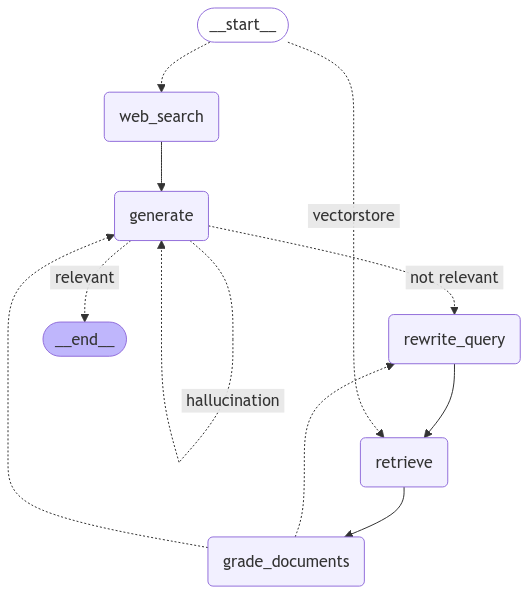

In [23]:
from azure_genai_utils.graphs import visualize_langgraph

visualize_langgraph(app, xray=True)

<br>

## 🧪 Step 3. Execute the Graph
---

### Execute the graph

In [24]:
from azure_genai_utils.messages import stream_graph, invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = {
    "question": "What is AutoGen's main features?",
}

stream_graph(app, inputs, config, ["grade_documents", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO VECTORSTORE] ====

==== [RETRIEVE] ====

==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====

🔄 Node: grade_documents 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score---GRADE: DOCUMENT RELEVANT---
":"yes"}{"binary---GRADE: DOCUMENT RELEVANT---
_score":"yes"}{"binary_score":"no"}---GRADE: DOCUMENT NOT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
{"binary_score":"yes"}---GRADE: DOCUMENT RELEVANT---
==== [DECISION TO GENERATE] ====
==== [DECISION: GENERATE] ====

==== [GENERATE] ====


🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
AutoGen is a versatile framework designed for building applications that utilize multiple 

In [25]:
inputs = {
    "question": "Who is Satya Nadella?",
}

stream_graph(app, inputs, config, ["agent", "rewrite", "generate"])

==== [ROUTE QUESTION] ====
==== [ROUTE QUESTION TO WEB SEARCH] ====
==== [WEB SEARCH] ====

==== [GENERATE] ====


🔄 Node: generate 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
Satya Nadella, born on August 19, 1967, in Hyderabad, India, is an Indian-born American business executive who has served as the Chairman and Chief Executive Officer (CEO) of Microsoft since February 4, 2014. He succeeded Steve Ballmer as CEO and John W. Thompson as chairperson in 2021. Nadella's educational background includes a bachelor's degree in electrical engineering from the Manipal Institute of Technology, a master's degree in computer science from the University of Wisconsin-Milwaukee, and an MBA from the University of Chicago Booth School of Business.

Before becoming CEO, Nadella held various leadership roles at Microsoft, including executive vice president of the Cloud and Enterprise group, where he was instrumental in the company's transition to cloud computing. His leadership has significan